## EDA - Amazon Buy Box Algo Modelling

In [1]:
import pandas as pd 
import numpy as np
from collections import defaultdict
from matplotlib.ticker import FuncFormatter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt

### A. Loading/Cleaning Data

In [3]:
# loading crawl2 data
crawl2 = pd.read_table("crawl2.txt")

In [4]:
# read in prime sids and algo seller sids
prime_sids = pd.read_table("prime_sids.txt", header=None, names=["prime_sids"])
algo_sellers = pd.read_table("susp_sids_all_with_amazon.txt", header=None, names=["algo_sids"])

In [5]:
# rename columns and merge prime/algo lists
crawl2.columns = ["pid", "epoc", "sid", "price", "sid_rating", "sid_pos_fb", "sid_rating_cnt", "shipping", "page", "rank", "pid_rating", "pid_rating_cnt", "is_fba", "is_prime", "bbox_sid", "bbox_price"]
crawl2["prime_seller"] = crawl2["sid"].isin(prime_sids["prime_sids"])
crawl2["algo_seller"] = crawl2["sid"].isin(algo_sellers["algo_sids"])

In [6]:
# how many unique pids?
unique_pids = crawl2["pid"].unique().tolist()
unique_pids
len(unique_pids)

987

In [7]:
# code for sampling data (for testing code)
sample_ids = np.random.choice(unique_pids, size=400, replace = False)
crawl_data_sample = crawl_data[crawl_data["pid"].isin(sample_ids)]

NameError: name 'crawl_data' is not defined

In [ ]:
# list of pids sorted in descending order by num of sellers
pidsandcount = crawl2.groupby("pid").agg({"pid" : "count"})
pidsandcount.columns = ["count"]
pidsandcount = pidsandcount.reset_index().sort_values(by="count", ascending=False)
pidsandcount.head(5)

,pid,count
600,B009IH0BYQ,30140
255,B001EOV492,30110
159,B000NCOKZQ,30110
681,B00DJPK8PA,30110
63,B0002E1P08,30100


In [ ]:
# copy data and add timestamp column from epoc
crawl_data = crawl2.copy()
crawl_data["timestamp"] = pd.to_datetime(crawl2['epoc'].astype(float), unit='s')
crawl_data

,pid,epoc,sid,price,sid_rating,sid_pos_fb,sid_rating_cnt,shipping,page,rank,pid_rating,pid_rating_cnt,is_fba,is_prime,bbox_sid,bbox_price,prime_seller,algo_seller,timestamp
0,0975277324,1439301853,A19HZ7QWHIRFQA,35.00,0.0,0,0,6.49,1,7,5.0,2321,yes,no,amazon,40.36,False,False,2015-08-11 14:04:13
1,0975277324,1439301853,A1G1QJKXJJSAN2,44.06,5.0,98,3761,3.99,2,9,5.0,2321,no,no,amazon,40.36,False,False,2015-08-11 14:04:13
2,0975277324,1439301853,A1H9LQ4XQ5IZ7D,39.99,5.0,97,1577,0.00,1,1,5.0,2321,yes,yes,amazon,40.36,True,False,2015-08-11 14:04:13
3,0975277324,1439301853,A1OUQ84L1EU4IB,36.99,5.0,100,2,6.49,2,1,5.0,2321,no,no,amazon,40.36,False,False,2015-08-11 14:04:13
4,0975277324,1439301853,A1PSEM5PTWSZBK,39.95,4.5,85,5308,6.10,2,4,5.0,2321,no,no,amazon,40.36,False,False,2015-08-11 14:04:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20740262,B01387NUN0,1440712515,A8UMA0WO93O39,5.95,5.0,100,3,0.00,1,1,1.0,3,no,no,A8UMA0WO93O39,5.95,False,False,2015-08-27 21:55:15
20740263,B01387NUN0,1440712515,AB62NOZUAODRB,10.99,5.0,100,770,4.75,1,9,1.0,3,no,no,A8UMA0WO93O39,5.95,False,False,2015-08-27 21:55:15
20740264,B01387NUN0,1440712515,AC9XK46ZTUENH,6.00,5.0,100,6,4.50,1,6,1.0,3,no,no,A8UMA0WO93O39,5.95,False,False,2015-08-27 21:55:15
20740265,B01387NUN0,1440712515,AS94HDKW3U98F,10.49,0.0,0,0,0.00,1,5,1.0,3,no,no,A8UMA0WO93O39,5.95,False,False,2015-08-27 21:55:15


### B. Recreating Figure 2 - CDF of Interval Between Changes for Sellers, Buybox Sellers, and Buybox Price

In [ ]:
def calculate_inter_update_times(df):
    # group by each product
    product_groups = df.groupby('pid')
    seller_price_update_times = []
    bbox_price_update_times = []
    bbox_seller_update_times = []

    
    for pid, group in product_groups:
        group = group.sort_values('timestamp')
        
        last_price_update = defaultdict(lambda: None)
        last_bbox_price = None
        last_bbox_seller = None
        
        for _, row in group.iterrows():
            timestamp = row['timestamp']
            seller_id = row['sid']
            bbox_price = row['bbox_price']
            bbox_seller = row['bbox_sid']
            
            # calc seller price update time
            if last_price_update[seller_id] is not None:
                time_diff = (timestamp - last_price_update[seller_id]).total_seconds()
                seller_price_update_times.append(time_diff)
            
            # calc buy box price update time
            if last_bbox_price is not None and bbox_price != last_bbox_price:
                time_diff = (timestamp - last_bbox_price[1]).total_seconds()
                bbox_price_update_times.append(time_diff)
                last_bbox_price = (bbox_price, timestamp)
            elif last_bbox_price is None:
                last_bbox_price = (bbox_price, timestamp)
            
            # calc buy box seller update time
            if last_bbox_seller is not None and bbox_seller != last_bbox_seller[0]:
                time_diff = (timestamp - last_bbox_seller[1]).total_seconds()
                bbox_seller_update_times.append(time_diff)
                last_bbox_seller = (bbox_seller, timestamp)
            elif last_bbox_seller is None:
                last_bbox_seller = (bbox_seller, timestamp)
            
            # update last price update time for this seller
            last_price_update[seller_id] = timestamp
    
    return seller_price_update_times, bbox_price_update_times, bbox_seller_update_times

In [ ]:
def plot_cumulative_distribution(seller_times, bbox_price_times, bbox_seller_times, save_path=None):
    seller_times = sorted(seller_times)
    bbox_price_times = sorted(bbox_price_times)
    bbox_seller_times = sorted(bbox_seller_times)
    
    seller_y = np.arange(1, len(seller_times) + 1) / len(seller_times)
    bbox_price_y = np.arange(1, len(bbox_price_times) + 1) / len(bbox_price_times)
    bbox_seller_y = np.arange(1, len(bbox_seller_times) + 1) / len(bbox_seller_times)
    
    fig, ax = plt.subplots()
    
    # convert times from seconds to minutes for plotting
    seller_times_min = [t / 60 for t in seller_times]
    bbox_price_times_min = [t / 60 for t in bbox_price_times]
    bbox_seller_times_min = [t / 60 for t in bbox_seller_times]
    
    # plot cumulative distributions
    ax.plot(seller_times_min, seller_y, 'b-', label='Seller Price Updates')
    ax.plot(bbox_price_times_min, bbox_price_y, 'g-', label='Buy Box Price Updates')
    ax.plot(bbox_seller_times_min, bbox_seller_y, 'r-', label='Buy Box Seller Updates')
    
    # cet log scale for x-axis
    ax.set_xscale('log')
    
    # format y-axis as percentage
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # add labels and title
    ax.set_xlabel('Inter-Update Time (minutes, log scale)')
    ax.set_ylabel('Cumulative Percentage')
    ax.set_title('Figure 2: Cumulative Distribution of Inter-Update Times')
    
    # add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')
    
    # customize x-axis ticks
    time_ticks = [1/60, 1/6, 1, 10, 60, 6*60, 24*60]
    time_labels = ['1s', '10s', '1m', '10m', '1h', '6h', '24h']
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_labels)
    
    # set axis limits
    min_time = min(bbox_seller_times_min)
    max_time = max([max(seller_times_min), max(bbox_price_times_min), max(bbox_seller_times_min)])
    ax.set_xlim(min_time * 0.8, max_time * 1.2)
    

In [ ]:
seller_times, bbox_price_times, bbox_seller_times = calculate_inter_update_times(crawl_data)

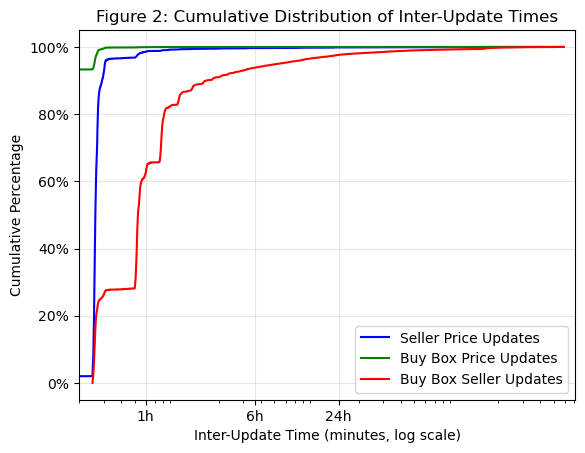

In [ ]:
plot_cumulative_distribution(seller_times, bbox_price_times, bbox_seller_times)

### B. Recreating Figure 9 - Probability of Winning Buy Box by Rank

In [ ]:
# calculate winrate by rank
crawl_data["wonbbox"] = crawl_data["bbox_sid"] == crawl_data["sid"]
crawl_data_winrate_by_rank = crawl_data.groupby("rank").agg({"wonbbox" : "mean"})
crawl_data_winrate_by_rank

,wonbbox
rank,
0,0.355975
1,0.105770
2,0.051780
3,0.032789
4,0.019421
5,0.014333
6,0.010299
7,0.007691
8,0.006677


Text(0.5, 1.0, 'Probability of Winning Buy Box by Rank')

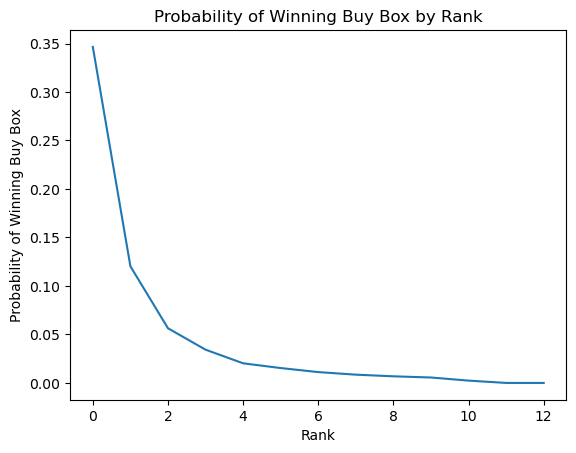

In [ ]:
# plot of winrate by rank
plt.plot(crawl_data_sample_winrate_by_rank.index, crawl_data_sample_winrate_by_rank['wonbbox'], linestyle='-')
plt.xlabel('Rank')
plt.ylabel('Probability of Winning Buy Box')
plt.title('Probability of Winning Buy Box by Rank')

### C. Recreation of RF Classifier - Table 1

In [ ]:
crawl_rf = crawl_data
crawl_rf["price_lowest"] = crawl_data.groupby("pid")["price"].transform("min")
crawl_rf["price_difference_to_lowest"] = crawl_rf["price"] - crawl_rf["price_lowest"]
crawl_rf["price_ratio_to_lowest"] = crawl_rf["price"]/crawl_rf["price_lowest"]
crawl_rf["positive_feedback"] = crawl_rf["sid_pos_fb"]
crawl_rf["is_amazon_seller"] = crawl_rf["sid"] == "amazon"
crawl_rf["feedback_count"] = crawl_rf["sid_rating_cnt"]
crawl_rf["average_rating"] = crawl_rf["sid_rating"]
crawl_rf["is_product_fba"] = crawl_rf["is_fba"] == "yes"
#sampling crawl_rf for faster code
rf_sample_ids = np.random.choice(unique_pids, size=200, replace = False)
crawl_rf_sample = crawl_rf[crawl_rf["pid"].isin(rf_sample_ids)]
X = crawl_rf_sample[["price_difference_to_lowest","price_ratio_to_lowest", "positive_feedback","is_amazon_seller","feedback_count", "average_rating","is_product_fba"]]
y = crawl_rf_sample["wonbbox"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9858
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    761349
        True       0.92      0.88      0.90     58505

    accuracy                           0.99    819854
   macro avg       0.95      0.94      0.95    819854
weighted avg       0.99      0.99      0.99    819854



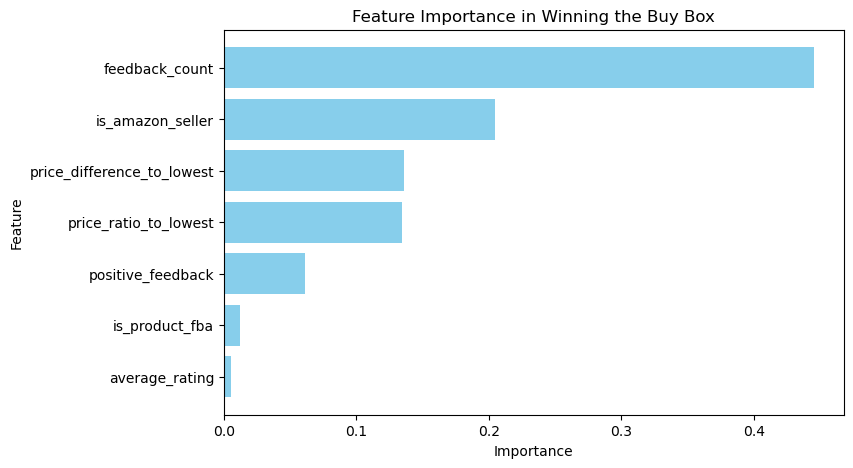

In [ ]:
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({'Feature': ["price_difference_to_lowest","price_ratio_to_lowest", "positive_feedback","is_amazon_seller","feedback_count", "average_rating","is_product_fba"], 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Winning the Buy Box")
plt.gca().invert_yaxis()
plt.show()

### D. Recreating Product-Wise Price to find instances of price matching

In [ ]:
unique_pids


['0975277324',
 'B00000J0RJ',
 'B00000JBNX',
 'B00002ND64',
 'B00004R9TL',
 'B00004RBDU',
 'B00004RIZ7',
 'B00004S7V8',
 'B00004SQLJ',
 'B00004TZY8',
 'B00004U9JO',
 'B00004UBGZ',
 'B00004UE29',
 'B00004YO15',
 'B00004YTJE',
 'B00004Z4A8',
 'B00004Z4CP',
 'B00004Z5SM',
 'B000052XHI',
 'B00005BXKM',
 'B00005O6B7',
 'B000067EH7',
 'B000067PCE',
 'B000067PQ0',
 'B000068O36',
 'B000068O3C',
 'B000068PBT',
 'B00006ANDK',
 'B00006I551',
 'B00006IBYA',
 'B00006IDV8',
 'B00006IEE4',
 'B00006IEEU',
 'B00006IEJC',
 'B00006IESK',
 'B00006IFAV',
 'B00006IFH0',
 'B00006IFKU',
 'B00006IUWA',
 'B00006JNN7',
 'B00006WNMJ',
 'B00008Y0VN',
 'B000096QQ5',
 'B00009IMCK',
 'B00009PGNT',
 'B0000AQOH2',
 'B0000AXRH5',
 'B0000CBK1L',
 'B0000YNR4M',
 'B0000YUXI0',
 'B00012YIA0',
 'B00016XJ4M',
 'B000197NXM',
 'B0001DSIVY',
 'B0001J3R3C',
 'B00026ZEDK',
 'B00028XJNA',
 'B00029WYEY',
 'B0002CZW0Y',
 'B0002D0CA8',
 'B0002D0CAI',
 'B0002D0HXA',
 'B0002E1G5C',
 'B0002E1P08',
 'B0002E7DIQ',
 'B0002FOBJY',
 'B0002GLC

### Comparing BuyBox Prices to different Sellers and Amazon

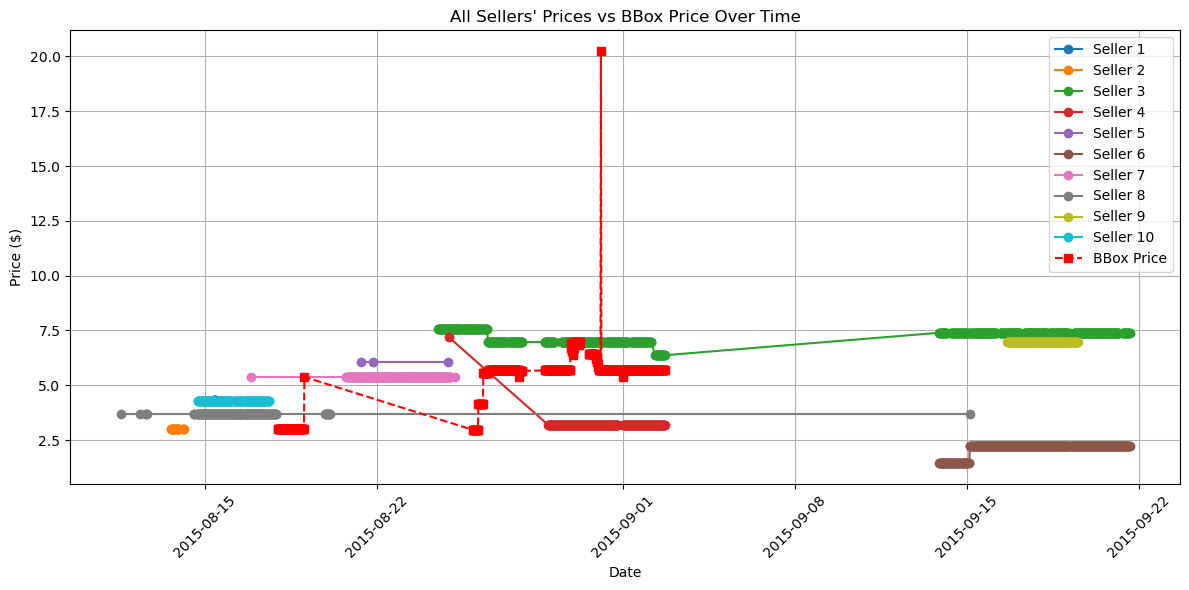

In [24]:
crawl2["date"] = pd.to_datetime(crawl2["epoc"], unit="s")

pid_sid_dict = crawl2.groupby("pid")["sid"].apply(list).to_dict()
pid_filtered_crawl2 = crawl2[crawl2["pid"]== "B00004YO15"]
amazon = pid_filtered_crawl2[pid_filtered_crawl2["sid"]== "amazon"]
# Sort values by date for better visualization
crawl2 = crawl2.sort_values(by="date")
# Plot 1: All Sellers vs BBox Price
plt.figure(figsize=(12, 6))
counter = 0
sellerLimit = 10

for sid, sid_df in pid_filtered_crawl2.groupby("sid"):
    if counter == sellerLimit:
        plt.plot(sid_df["date"], sid_df["bbox_price"], 
                label="BBox Price", marker="s", linestyle="--", color="red")
        break
    counter += 1
    plt.plot(sid_df["date"], sid_df["price"], 
            marker="o", linestyle="-", label=f"Seller {counter}")

plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.title("All Sellers' Prices vs BBox Price Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

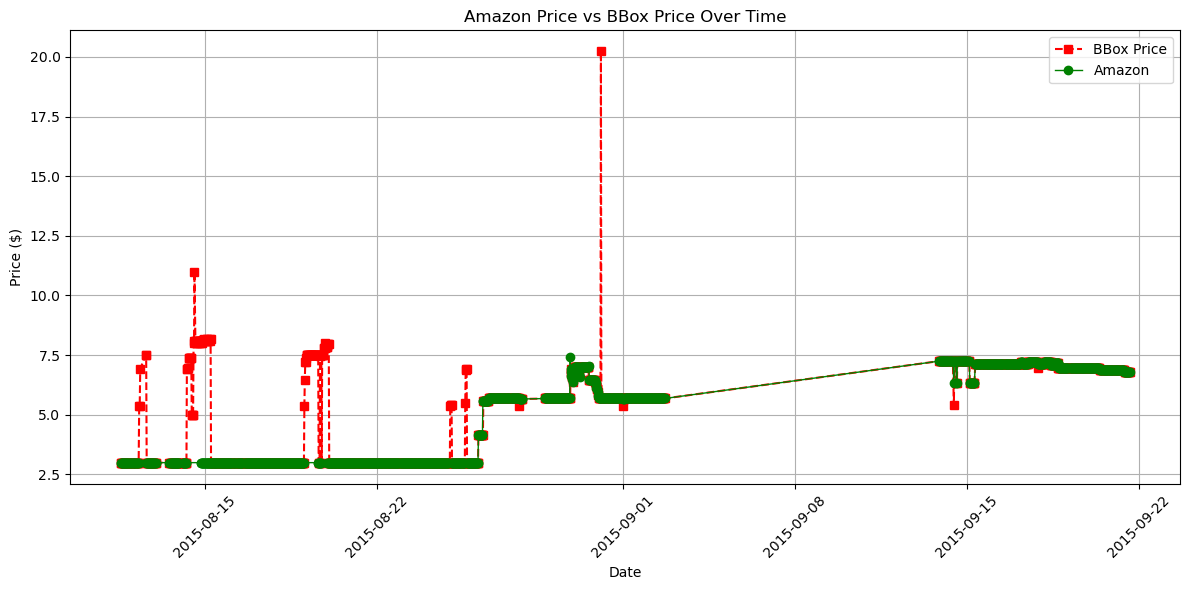

In [25]:
# Plot 2: Amazon vs BBox Price
plt.figure(figsize=(12, 6))

plt.plot(pid_filtered_crawl2["date"].unique(), 
         pid_filtered_crawl2.groupby("date")["bbox_price"].first(), 
         label="BBox Price", marker="s", linestyle="--", color="red")
plt.plot(amazon["date"], amazon["price"], 
         marker="o", linestyle="-", label="Amazon", color="green", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.title("Amazon Price vs BBox Price Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

BuyBox Holder Summary:


,seller_id,bbox_count,bbox_duration_hours,avg_bbox_price,min_bbox_price,max_bbox_price
0,amazon,27300,984.558333,4.890366,2.97,10.99
17,A3SQ9YFE6CSCS0,500,21.666667,7.641200,7.49,7.97
8,A2CLSPX77ALNG9,420,266.019167,6.988095,2.97,8.09
16,A2QOXDNDKR686Q,420,156.166944,7.446667,6.88,7.49
12,A2P0IMBKY7X8NS,180,6.505000,8.130000,8.13,8.13
5,A3L4J771ECRA97,160,114.671667,7.380000,7.38,7.38
23,A23V8PCI306MKW,100,10.518889,6.700000,6.44,6.92
1,ACRYPPG8EYXHP,100,472.030278,5.380000,5.38,5.38
13,A3G2RBEZBLAJ53,100,6.504722,8.190000,8.19,8.19
11,A2P5I4NW0QQAX1,80,2.635000,8.020000,8.02,8.02



Plotting price history and BuyBox ownership...


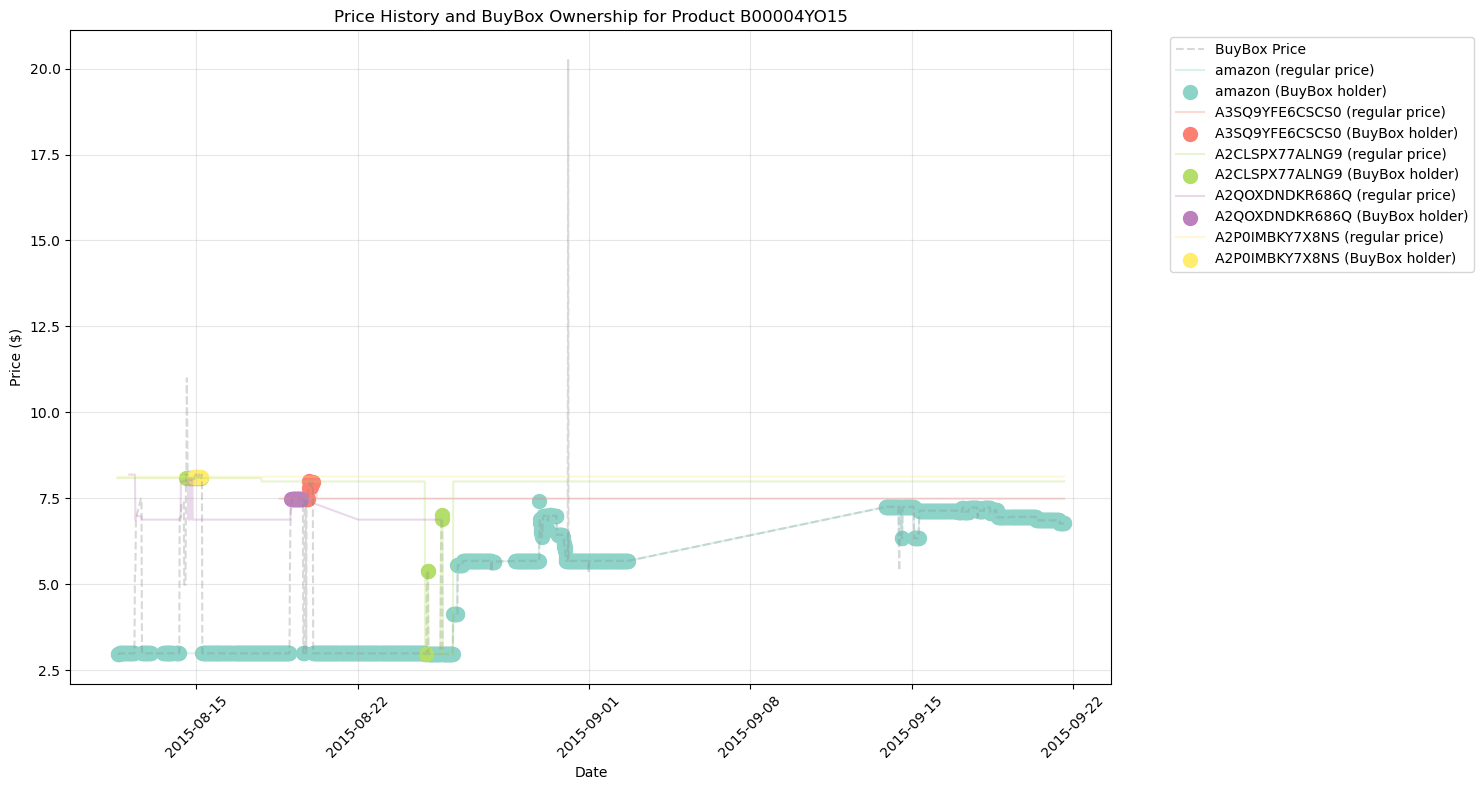


Analyzing price changes for top sellers:

Seller: amazon
Times entered BuyBox: 24
Times left BuyBox: 0
Average price when entering BuyBox: $4.94
Total time in BuyBox: 984.56 hours

Seller: A3SQ9YFE6CSCS0
Times entered BuyBox: 14
Times left BuyBox: 0
Average price when entering BuyBox: $7.63
Total time in BuyBox: 21.67 hours

Seller: A2CLSPX77ALNG9
Times entered BuyBox: 22
Times left BuyBox: 0
Average price when entering BuyBox: $7.28
Total time in BuyBox: 266.02 hours


In [26]:


def analyze_buybox_sellers(df, product_id):
    """Analyze BuyBox holder statistics for a given product."""
    product_data = df[df['pid'] == product_id].copy()
    product_data = product_data.sort_values('date')
    
    # Get unique BuyBox sellers
    buybox_sellers = product_data['bbox_sid'].unique()
    
    # Create a summary of BuyBox holders
    bbox_summary = []
    for seller in buybox_sellers:
        seller_data = product_data[product_data['bbox_sid'] == seller]
        bbox_count = len(seller_data)
        bbox_duration = (seller_data['date'].max() - seller_data['date'].min()).total_seconds() / 3600  # in hours
        avg_price = seller_data['bbox_price'].mean()
        min_price = seller_data['bbox_price'].min()
        max_price = seller_data['bbox_price'].max()
        
        bbox_summary.append({
            'seller_id': seller,
            'bbox_count': bbox_count,
            'bbox_duration_hours': bbox_duration,
            'avg_bbox_price': avg_price,
            'min_bbox_price': min_price,
            'max_bbox_price': max_price
        })
    
    return pd.DataFrame(bbox_summary).sort_values('bbox_count', ascending=False)

def plot_buybox_seller_prices(df, product_id, top_n_sellers=5):
    """Plot price history and BuyBox ownership for top sellers of a product."""
    product_data = df[df['pid'] == product_id].copy()
    product_data = product_data.sort_values('date')
    
    # Get top N BuyBox sellers by frequency
    top_sellers = product_data['bbox_sid'].value_counts().head(top_n_sellers).index
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    # Plot BuyBox price line
    plt.plot(product_data['date'], product_data['bbox_price'], 
             color='gray', alpha=0.3, linestyle='--', label='BuyBox Price')
    
    # Plot each seller's price history
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_sellers)))
    for seller, color in zip(top_sellers, colors):
        # Get all price points for this seller
        seller_data = product_data[product_data['sid'] == seller]
        
        # Plot regular price points
        plt.plot(seller_data['date'], seller_data['price'], 
                 alpha=0.3, color=color, label=f'{seller} (regular price)')
        
        # Plot points where this seller had the BuyBox
        bbox_data = product_data[(product_data['sid'] == seller) & 
                                (product_data['bbox_sid'] == seller)]
        if not bbox_data.empty:
            plt.scatter(bbox_data['date'], bbox_data['price'], 
                       color=color, s=100, label=f'{seller} (BuyBox holder)')
    
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.title(f'Price History and BuyBox Ownership for Product {product_id}')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return top_sellers

def analyze_price_changes(df, product_id, seller_id):
    """Analyze price changes when entering/leaving BuyBox for a specific seller."""
    product_data = df[df['pid'] == product_id].copy()
    seller_data = product_data[product_data['sid'] == seller_id].copy()
    
    # Mark when seller enters/leaves BuyBox
    seller_data['in_buybox'] = seller_data['bbox_sid'] == seller_id
    seller_data['buybox_change'] = seller_data['in_buybox'].diff()
    
    # Analyze price changes around BuyBox transitions
    enter_bbox = seller_data[seller_data['buybox_change'] == 1]
    leave_bbox = seller_data[seller_data['buybox_change'] == -1]
    
    stats = {
        'entries': len(enter_bbox),
        'exits': len(leave_bbox),
        'avg_price_entering': enter_bbox['price'].mean() if len(enter_bbox) > 0 else None,
        'avg_price_leaving': leave_bbox['price'].mean() if len(leave_bbox) > 0 else None,
        'total_time_in_bbox': seller_data[seller_data['in_buybox']]['date'].diff().sum().total_seconds() / 3600
    }
    
    return stats, seller_data

# Example usage with a specific product
example_pid = "B00004YO15"  # You can change this to analyze different products

# Get summary of BuyBox holders
print("BuyBox Holder Summary:")
bbox_summary = analyze_buybox_sellers(crawl2, example_pid)
display(bbox_summary)

# Plot price history and BuyBox ownership
print("\nPlotting price history and BuyBox ownership...")
top_sellers = plot_buybox_seller_prices(crawl2, example_pid, top_n_sellers=5)

# Analyze price changes for top sellers
print("\nAnalyzing price changes for top sellers:")
for seller in top_sellers[:3]:  # Analyze top 3 sellers
    stats, _ = analyze_price_changes(crawl2, example_pid, seller)
    print(f"\nSeller: {seller}")
    print(f"Times entered BuyBox: {stats['entries']}")
    print(f"Times left BuyBox: {stats['exits']}")
    if stats['avg_price_entering'] is not None:
        print(f"Average price when entering BuyBox: ${stats['avg_price_entering']:.2f}")
    if stats['avg_price_leaving'] is not None:
        print(f"Average price when leaving BuyBox: ${stats['avg_price_leaving']:.2f}")
    print(f"Total time in BuyBox: {stats['total_time_in_bbox']:.2f} hours")